# Preprocessing

## Calculate $dF/F0$ via `matlab`

To extract measure (correlation coefficient, distance, mutual information and variation of information) pairwise matrices. 

Before running this, run `matlab/preprocess_matfiles.m` first. This normalizes raw fluorescence data to $dF/F_0$ (median smoothing, then performed $(F-F_0)/F_0$ where $F_0$ is a certain percentile of the raw data, then with additional smoothing)

## Initialization

In [1]:
import os, glob, time, pickle, re
import numpy as np 
from scipy.io import loadmat
from scipy.stats import entropy
from tqdm.notebook import tqdm
from src.utils import *

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams, font_manager
import seaborn as sns

%matplotlib inline

rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')

# use one of the available styles 
plt.style.use('seaborn-notebook')

# further customization
rcParams['font.family'] = 'FreeSans'
rcParams['font.size'] = 20 

rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['legend.fontsize'] = 18
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['axes.linewidth'] = 1
rcParams['lines.linewidth'] = 2 

rcParams['mathtext.fontset'] = 'cm' 
rcParams['mathtext.rm'] = 'serif'
rcParams['figure.dpi'] = 200



## Load file

In [3]:
preproc_path = 'data/preprocessed/' 
preproc_file = 'purkpop-dFF0.mat'
select_trial_ids = range(65,190) # select trials 065-189

# Load file
preproc_dFF0 = loadmat(preproc_path + preproc_file)
dFF0 = preproc_dFF0['dF_F0']
trial_ids = preproc_dFF0['trial_ids']
data_info = preproc_dFF0['info']

# Select trials 
select_inds = np.where(trial_ids == select_trial_ids)[0] 
dFF0 = [x[0] for x in dFF0[select_inds]]
trial_ids = trial_ids[select_inds].flatten()
data_info = {k:float(x[0][0]) if isinstance(x[0], np.ndarray) and len(x) == 1 else x[0] 
             for (k,x) in zip(list(data_info.dtype.fields.keys()),data_info[0][0])}
del preproc_dFF0 # dont need anymore, clear from memory 

In [4]:
data_info

{'description': 'Calcium imaging of Purkinje cell population',
 'experimenter': 'Silas Busch, Ting-Feng Lin, Christian Hansel',
 'data_source': '012_018_XXX_OUT_MotCor ROI analysis.mat',
 'Fs': 60.0,
 'T': 20.0,
 't_stim': 10.0,
 'preprocess': 'smoothdata(MOVMEDIAN, 10 pnts)\n[ (F-F0)/F0 ] (F0=5.0-th percentile)\nsmoothdata(GAUSS, 10 pnts)'}

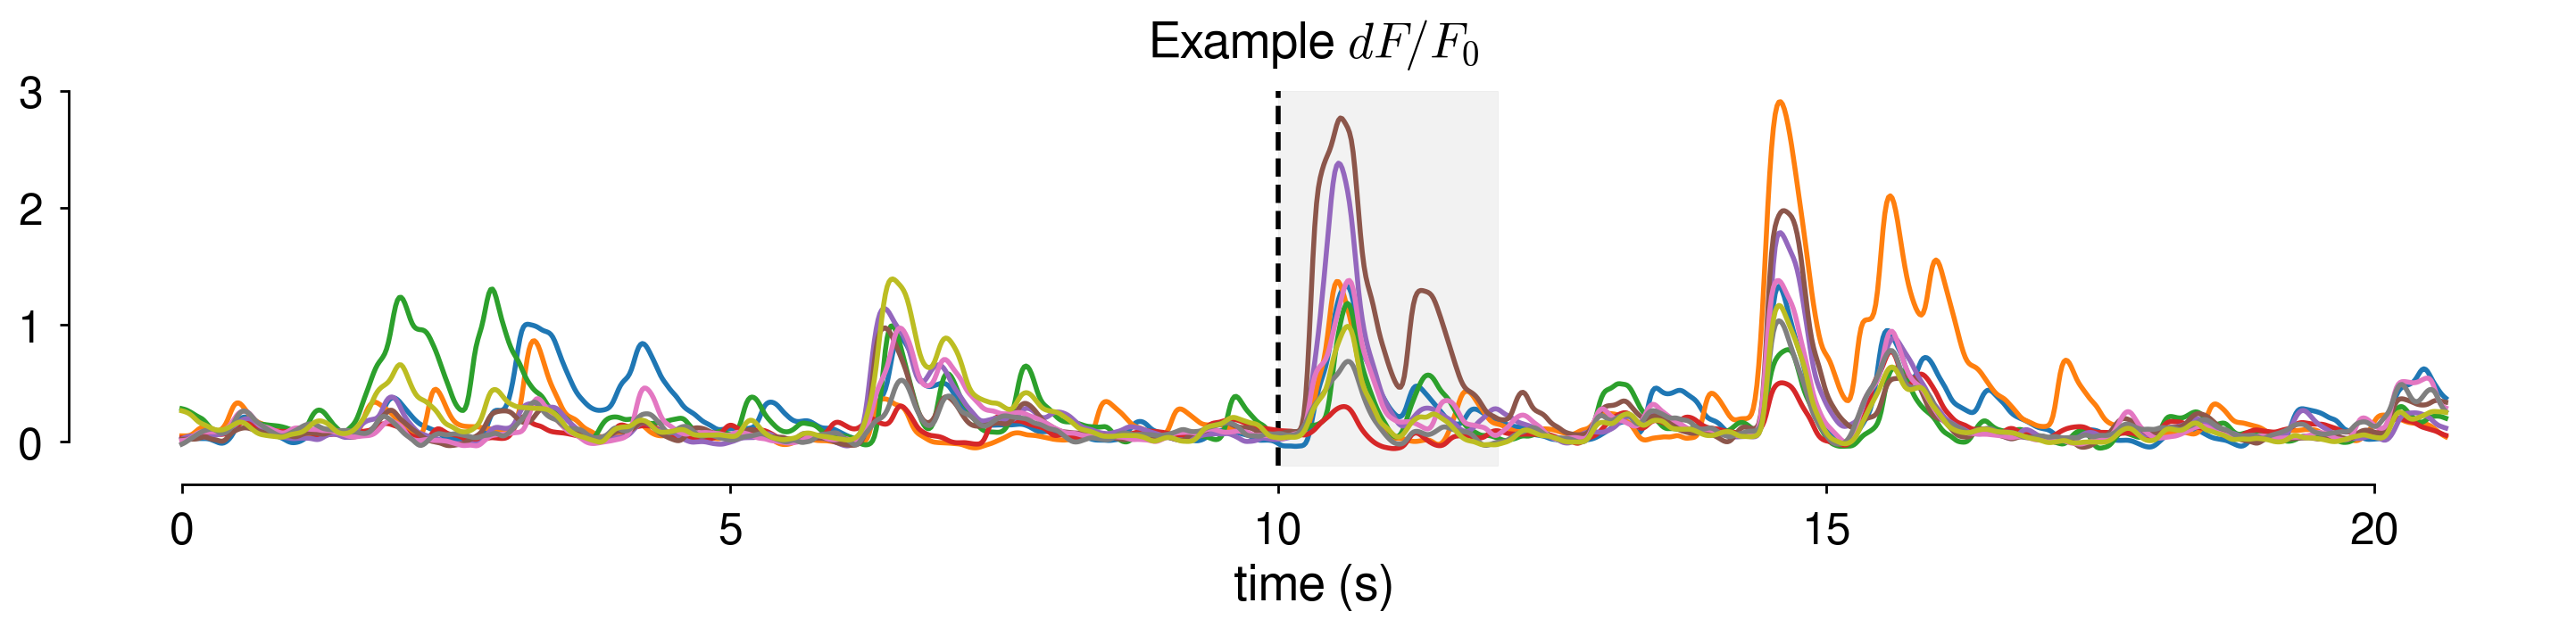

In [37]:
y = dFF0[30][:,1:10]
t = np.arange(0,y.shape[0]) / data_info['Fs']

# plt.figure(figsize=(20,5))
plt.figure(figsize=(18,3)) # for figure making
plt.plot(t, y)

plt.vlines(data_info['t_stim'],-0.2,3,linestyles='--',colors='k') # stim 
plt.gca().add_patch(plt.Rectangle((data_info['t_stim'], -0.2), 2, 3.2, color='k', alpha=0.05, fill=True)) # analyzed window 

plt.title('Example $dF/F_0$')
plt.xlabel('time (s)')
sns.despine(trim = True)

plt.show()

## Extract some activity features

In [21]:
# select time window for calculation of measures 
t_stim = [10, 12] # 2 sec after stim on
t_base = [5, 10] # baseline 

# converted index range of selected time window
ind_stim = (data_info['Fs'] * np.array(t_stim)).astype(int)
ind_base = (data_info['Fs'] * np.array(t_base)).astype(int)

activity_features = dict(
    max = [],
    mean = [],
    dmax = [], 
    dmean = [], 
)

t0 = time.time()

for dFF0_trial in tqdm(dFF0):
    dff0_stim = dFF0_trial[ind_stim[0]:ind_stim[1],:]    
    dff0_base = dFF0_trial[ind_base[0]:ind_base[1],:]    
    
    max_stim = np.max(dff0_stim, axis=0)
    max_base = np.max(dff0_base, axis=0)
    mean_stim = np.mean(dff0_stim, axis=0)
    mean_base = np.mean(dff0_base, axis=0)
    
    activity_features['max'].append(max_stim)
    activity_features['mean'].append(mean_stim)
    activity_features['dmax'].append(max_stim - max_base)
    activity_features['dmean'].append(mean_stim - mean_base)

t1 = time.time()
print('Elapsed times = %.2f min' %((t1-t0)/60))

    
data_file_pref = 'multisensory-activity-features'
data_info['data_source'] += '\n' + preproc_file
data_info['selection'] = dict(
    time_window = {'base': t_base, 'stim': t_stim}, 
    trial_list = select_trial_ids
)

with open(preproc_path + data_file_pref + '.pkl','wb') as f:
    pickle.dump(dict(
        info=data_info,
        activity_features=activity_features
    ),f)

  0%|          | 0/125 [00:00<?, ?it/s]

Elapsed times = 0.00 min


## Extract stimulus tags

In [6]:
raw_path = 'data/raw/' 
stim_file = 'Stimlog20201218_2.txt' # this contains info on 065-189
shift_ind = 65 
trial_ind_range = list(select_trial_ids)
trial_ind_range = [trial_ind_range[0], trial_ind_range[-1]]

with open(raw_path + stim_file, 'r') as f:
    stim_content = f.readlines() 

stim_content = list(filter(lambda v: re.match('^\d+,\s*\d+,\s*[a-zA-Z]+', v), stim_content))
stim_content = [re.sub('[\s+]', '', x).split(',') for x in stim_content]

stim_trial_ids = np.array([int(x[0]) + shift_ind for x in stim_content])
stim_types = np.array([x[2] for x in stim_content])

filt_ind = np.logical_and(stim_trial_ids >= trial_ind_range[0], stim_trial_ids <= trial_ind_range[-1])
stim_trial_ids = stim_trial_ids[filt_ind]
stim_types = stim_types[filt_ind]

stim_preproc_file = 'purkpop-stim.pkl'    
with open(preproc_path + stim_preproc_file,'wb') as f:
    pickle.dump(dict(
        source=raw_path + stim_file,
        stim_types=stim_types,
        trial_ids=stim_trial_ids,
    ),f)

## Calculting information and correlation

In [6]:
# select time window for calculation of measures 
t_range = [10, 12] # 2 sec after stim on 
hist_nbin = 50 # histogram number of bins for entropy calculation  

ind_range = (data_info['Fs'] * np.array(t_range)).astype(int) # converted index range of selected time window
# obtain range for histogram for entropy calculation 
dFF0_range = [np.min([np.min(x) for x in dFF0]), np.max([np.max(x) for x in dFF0])]
hist_range = np.array([dFF0_range,dFF0_range])

measures = dict(
    mutual_info = [],
    var_info = [],
    corr_coef = [], 
    corr_dist = [], 
)

t0 = time.time()

for dFF0_trial in tqdm(dFF0):
    dff0 = dFF0_trial[ind_range[0]:ind_range[1],:]    
    I_X, V_X = calc_parwise_info(dff0,hist_nbin,hist_range)
    R_X, dR_X = calc_pairwise_corr(dff0)

    measures['mutual_info'].append(I_X)
    measures['var_info'].append(V_X)
    measures['corr_coef'].append(R_X)
    measures['corr_dist'].append(dR_X)

t1 = time.time()
print('Elapsed times = %.2f min' %((t1-t0)/60))

  0%|          | 0/125 [00:00<?, ?it/s]

Elapsed times = 1.79 min


In [9]:
# Save files
data_file_pref = 'multisensory-measures-'
data_info['data_source'] += '\n' + preproc_file
data_info['selection'] = dict(
    time_window = t_range, 
    trial_list = select_trial_ids
)

data_info['measures_path'] = dict()

for k,v in measures.items():
    file_name = preproc_path + data_file_pref + k + '.npz'
    data_info['measures_path'][k] = file_name
    np.savez(file_name, X=v)
    
with open(preproc_path + data_file_pref + 'info.pkl','wb') as f:
    pickle.dump(dict(
        info=data_info,
        trial_ids=trial_ids
    ),f)

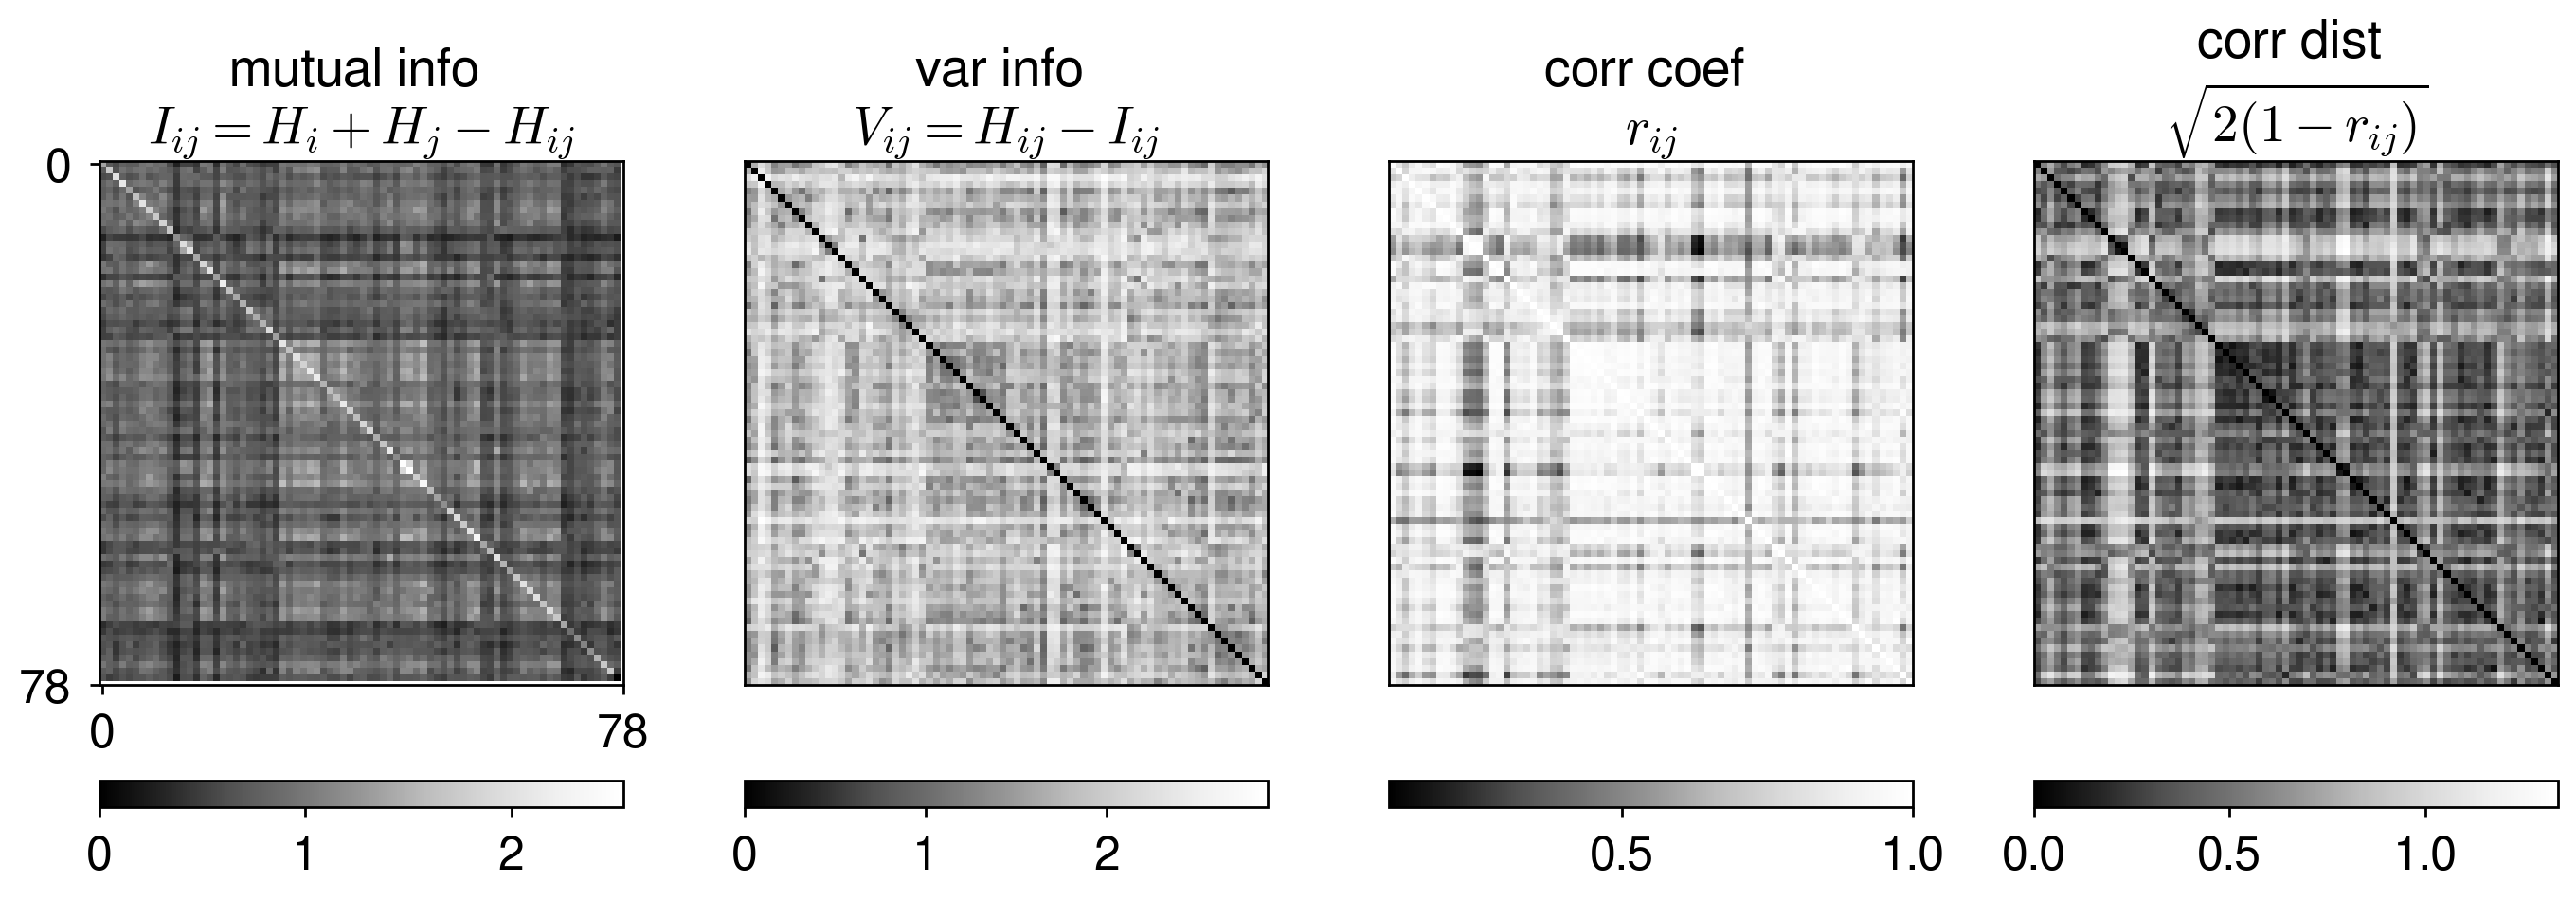

In [32]:
latex_names = dict(
    mutual_info = 'I_{ij} = H_i + H_j - H_{ij}',
    var_info = 'V_{ij} = H_{ij} - I_{ij}',
    corr_coef = 'r_{ij}',
    corr_dist = '\sqrt{2(1 - r_{ij})}'
)

# plt.figure(figsize=(25,10))
plt.figure(figsize=(14,6)) # for figure making

for i,(k,v) in enumerate(measures.items()):
    plt.subplot(1,4,i+1)
    M = v[84]
    n = len(M)
    im = plt.imshow(M, cmap='Greys_r')
    plt.title('%s \n$%s$' %(re.sub('_', ' ', k),latex_names[k]))
    plt.colorbar(im, fraction=0.04, pad=0.10, orientation='horizontal')
    if i == 0:
        plt.xticks([0,n])
        plt.yticks([0,n])
    else:
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()